In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import pickle as pkl
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,make_scorer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from math import log
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# %pylab inline

def plot_prob_timeline(data,label):
    xtick = range(0, 91, 10)
    fig = plt.figure()
    plt.plot(data)
    fig.suptitle(label, fontsize=20)
    plt.ylim([0,1])
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Probability', fontsize=16)
    plt.xticks(xtick)

def eval_probs(y_prob,y_test, labels=[-1,0,1],show_plot=False):
    """
    y_prob : predict_proba output of a model
    labels : all unique labels in the classification
    """
    vals = []
    titles = {}
    titles[-1] = "Away Win"
    titles[0] = "Draw"
    titles[1] = "Home Win"

    y_prob = pd.DataFrame(y_prob, columns=[-1, 0, 1])
    y_prob = y_prob.round(1)
    y_prob['label'] = y_test.reset_index(drop=True)
    slopes= []
    total_error = 0
    for ind, label in enumerate(labels):
        vals = sorted(y_prob[label].unique())
        
        y_col = []
        
        
        for i in vals:
            tot_len = y_prob[(y_prob[label] == i)].shape[0]
            matching_len = y_prob[(y_prob[label] == i) & (y_prob['label'] == label)].shape[0]
            y_col.append(matching_len*1.0/tot_len)
        
        index = 0
        y_true = 0
        for i in range(10):
            if index == len(y_col):
                y = 0
            else:
                y = y_col[index]
                index+=1
            total_error+= (y_true - y)**2
            y_true+=0.1

        if show_plot:
            plt.figure(figsize=(7,21))
            plt.subplot(311+ind)
            plt.bar(vals, y_col, width=0.05)
            plt.title(titles[label], fontsize=16)
            plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=8)
            plt.yticks(np.arange(0.0, 1.1, 0.1),fontsize=8)
            plt.show()
    return total_error ** 0.5
        
    
def save_model(model, model_name):
    saved_models_root = "./saved_models/" 
    filename = saved_models_root + model_name + datetime.now().strftime('%m%d_%H%M%S') + ".pkl"
                                                 
    with open(filename, 'wb') as outfile:
        pkl.dump(model, outfile)

In [36]:
with open("./data/train/train_data.pkl") as infile:
    train_data = pkl.load(infile)

# with open("./data/train/train_data_with_team_attr.pkl") as infile:
#     train_data = pkl.load(infile)

In [37]:
# train_data.columns.values
temp_data = train_data.copy(deep = True)

In [3]:
train_data.columns.values

array(['season', 'stage', 'date_x', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10',
       'away_player_11', 'goal', 'shoton', 'shotoff', 'foulcommit', 'card',
       'cross', 'corner', 'possession', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH',
       'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA', 'home_team',
       'away_team', 'buildUpPlaySpeed_x', 'buildUpPlayPassing_x',
       'chanceCreationPassing_x', 'chanceCreationCrossing_x',
       'chan

In [4]:
train_data.columns.values

array(['season', 'stage', 'date_x', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10',
       'away_player_11', 'goal', 'shoton', 'shotoff', 'foulcommit', 'card',
       'cross', 'corner', 'possession', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH',
       'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA', 'home_team',
       'away_team', 'buildUpPlaySpeed_x', 'buildUpPlayPassing_x',
       'chanceCreationPassing_x', 'chanceCreationCrossing_x',
       'chan

In [5]:
# train_data.home_team

In [6]:
columns = ['date', 'B365H', 'B365D', 'B365A', 'match_id', 'home_team', 'away_team', 
           'winner', 'minute', 'H_Goal', 'A_Goal','buildUpPlaySpeed_x', 'buildUpPlayPassing_x',
       'chanceCreationPassing_x', 'chanceCreationCrossing_x',
       'chanceCreationShooting_x', 'defencePressure_x',
       'defenceAggression_x', 'defenceTeamWidth_x', 'buildUpPlaySpeed_y',
       'buildUpPlayPassing_y', 'chanceCreationPassing_y',
       'chanceCreationCrossing_y', 'chanceCreationShooting_y',
       'defencePressure_y', 'defenceAggression_y', 'defenceTeamWidth_y','goal_diff','home_avg_player_rating',
       'home_avg_player_potential', 'away_avg_player_rating',
       'away_avg_player_potential','H_Y_Card', 'A_Y_Card', 'H_R_Card', 'A_R_Card']
train_data = train_data[columns]

In [7]:
train_data.shape

(152166, 36)

In [44]:
# train_data.card.value_counts()

In [45]:
# train_data[(train_data['match_id']==1510566245714) & (train_data['minute']>=45)]

In [211]:
train_data.drop_duplicates(inplace=True, keep='first')

In [47]:
# train_data.match_id.value_counts()

In [8]:
# X = train_data.drop(['winner', 'date', 'match_id', 'home_team', 'away_team'], axis=1)
X = train_data.drop(['winner', 'date', 'home_team', 'away_team'], axis=1)

Y = train_data['winner']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Support Vector Classifier

In [ ]:
svc = svm.SVC(probability=True,cache_size=99999)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = svc.predict_proba(X_test)

## Logistic Regression

In [16]:
lr = LogisticRegression(n_jobs=-1,solver='saga',class_weight='balanced')
lr.fit(X_train_scaled,y_train)

y_pred = lr.predict(X_test_scaled)

print metrics.accuracy_score(y_test, y_pred)

y_prob = lr.predict_proba(X_test_scaled)

# eval_probs(y_prob, y_test, [-1,0,1])

0.635604915555


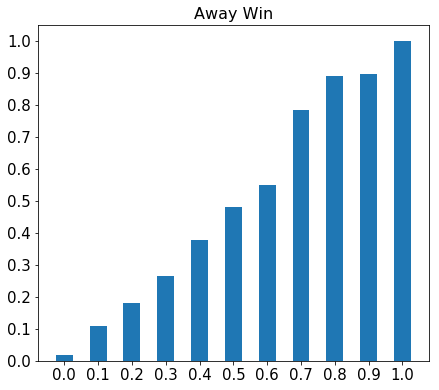

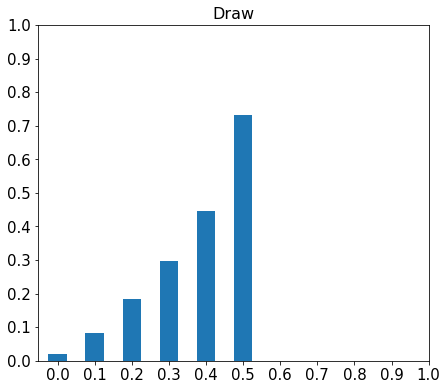

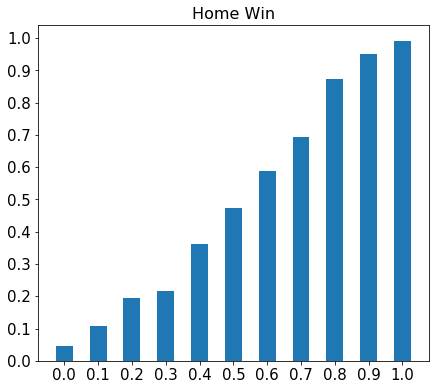

1.0692548508561188

In [62]:
eval_probs(y_prob, y_test, [-1,0,1], True)

In [16]:
temp_data = temp_data[columns]
X = temp_data.drop(['winner'], axis=1)
Y = temp_data['winner']
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X, Y, test_size=0.1,shuffle= False)


In [63]:
# head = X_testA #1510605206930   1510602646114
# match_data = head.loc[head['match_id'] == 1510605206930]
# match_data=match_data.drop([  'date', 'match_id', 'home_team', 'away_team'], axis=1)
# y_prob= lr.predict_proba(match_data)


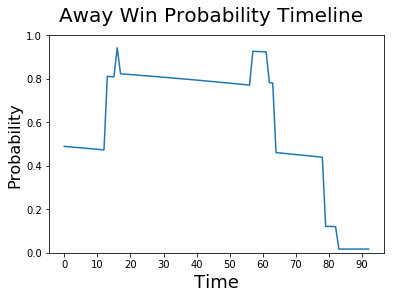

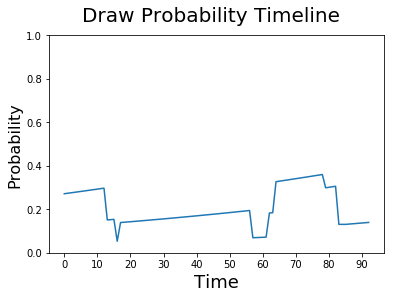

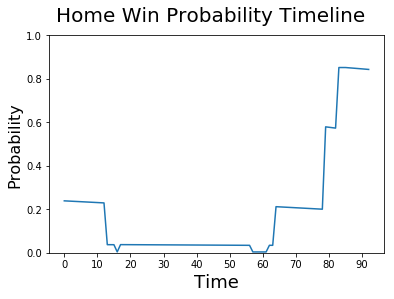

In [142]:
plot_prob_timeline(y_prob[:,0],'Away Win Probability Timeline')
plot_prob_timeline(y_prob[:,1],'Draw Probability Timeline')
plot_prob_timeline(y_prob[:,2],'Home Win Probability Timeline')

In [132]:
# y_zzzzprob[:,0],'Away Win Probability Timeline'


## K nearest neighbours

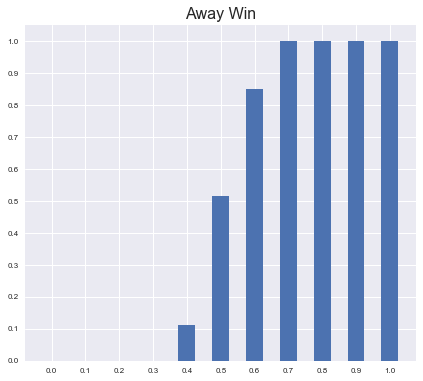

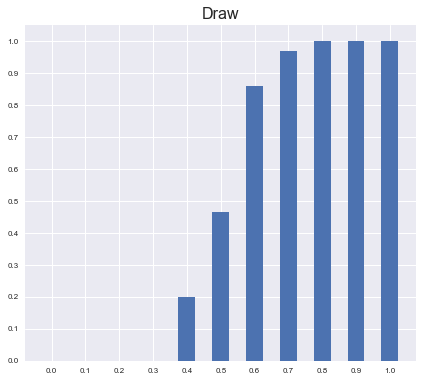

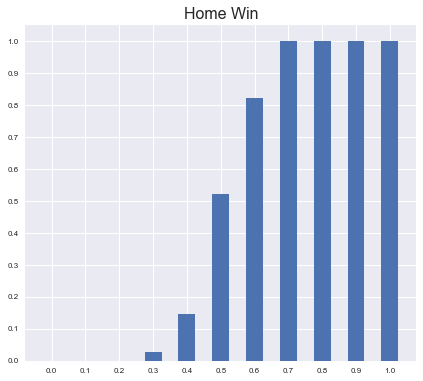

1.08453547918


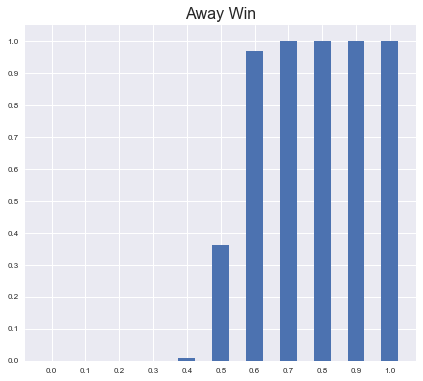

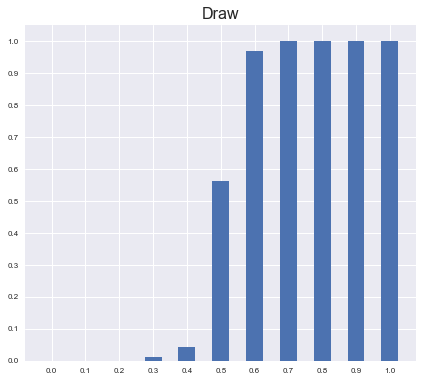

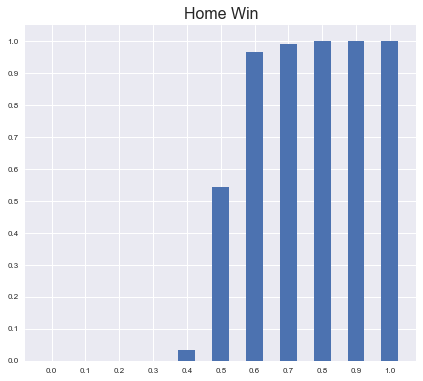

1.2936565473


In [20]:
#last checked, worked better with scaled data (0.98 RMSE)
for weight in ['uniform' , 'distance']:

    neigh = KNN(n_neighbors=15, algorithm='auto', weights=weight, n_jobs=-1)
    neigh.fit(X_train, y_train) 
    
    y_pred = neigh.predict(X_test)

#     print metrics.accuracy_score(y_test, y_pred)

    y_prob = neigh.predict_proba(X_test)
    print eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)    
    
    
#     save_model(neigh, "KNN"+weight)

## Random Forest Classifier

0.897613190612


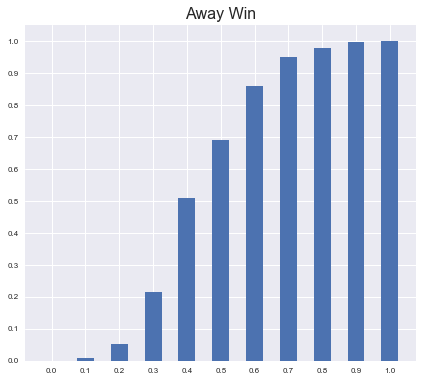

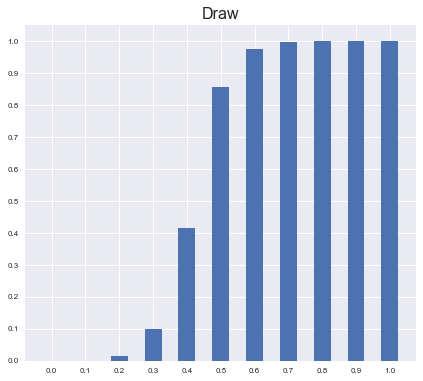

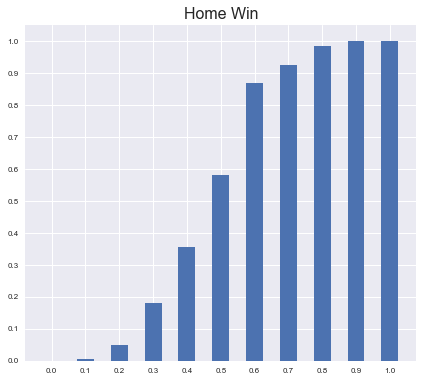

0.9834192084063782

In [191]:
rf = RandomForestClassifier(n_estimators=10,max_depth=10,n_jobs=-1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = rf.predict_proba(X_test)

eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)

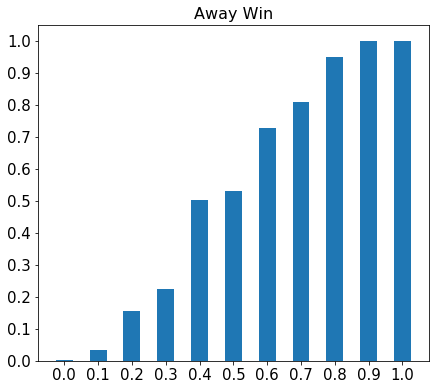

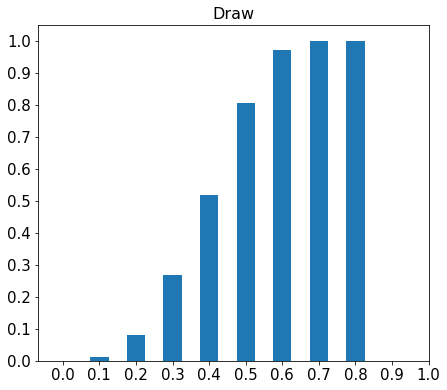

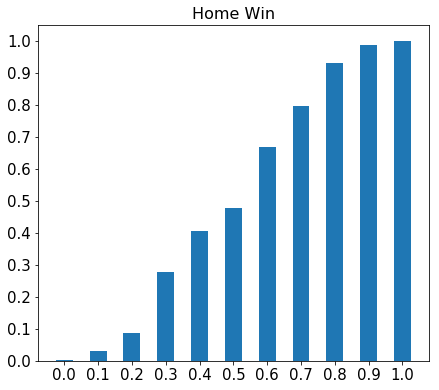

(135363, 23)

In [153]:
X_train.shape

Iteration 1, loss = 1.03102490
Iteration 2, loss = 0.95078265
Iteration 3, loss = 0.88092644
Iteration 4, loss = 0.82999225
Iteration 5, loss = 0.79343748
Iteration 6, loss = 0.77097078
Iteration 7, loss = 0.75631682
Iteration 8, loss = 0.74658438
Iteration 9, loss = 0.73958075
Iteration 10, loss = 0.73291351
Iteration 11, loss = 0.72674619
Iteration 12, loss = 0.72095375
Iteration 13, loss = 0.71547316
Iteration 14, loss = 0.71012680
Iteration 15, loss = 0.70533465
Iteration 16, loss = 0.70024952
Iteration 17, loss = 0.69535268
Iteration 18, loss = 0.69038186
Iteration 19, loss = 0.68547498
Iteration 20, loss = 0.68076769
Iteration 21, loss = 0.67604611
Iteration 22, loss = 0.67170335
Iteration 23, loss = 0.66646215
Iteration 24, loss = 0.66202555
Iteration 25, loss = 0.65720733
Iteration 26, loss = 0.65270170
Iteration 27, loss = 0.64823310
Iteration 28, loss = 0.64345485
Iteration 29, loss = 0.63861490
Iteration 30, loss = 0.63396102
Iteration 31, loss = 0.62964129
Iteration 32, los

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.857323316269


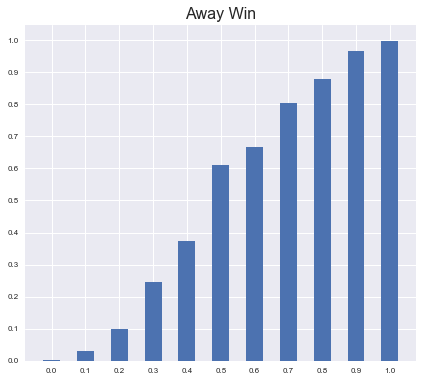

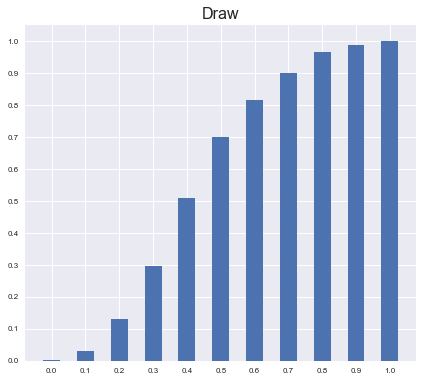

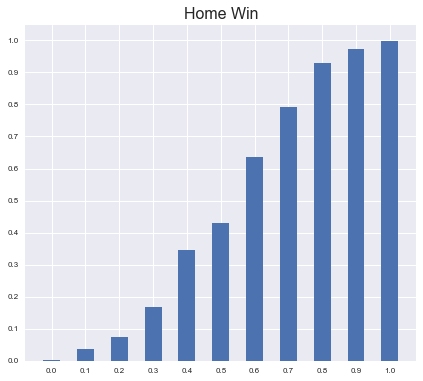

0.5627537664345992

In [200]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),activation='logistic',solver='adam',learning_rate='constant',
                    learning_rate_init=0.0001,max_iter=100,early_stopping=False, tol=0.0005, verbose=True)
mlp.fit(X_train,y_train)

y_pred = mlp.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = mlp.predict_proba(X_test)

eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)
# X_test.columns.values